In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymc import Model, Normal, sample, HalfNormal
import arviz as az

import yfinance as yf
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
start = '2014-12-31'
end = '2022-12-31'
ext_factors = pd.read_parquet('factors.parquet')
stock_prices = pd.read_parquet('stock_data.parquet')
stock_prices = stock_prices.loc[start:end, :]

stock_rets = stock_prices.pct_change()
ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
stock_rets = stock_rets.resample('M').agg(lambda x: (x + 1).prod() - 1)

ext_factors[[f'{factor}_lag' for factor in ext_factors.columns]] = ext_factors.shift(1)
stock_rets[[f'{symbol}_lag' for symbol in stock_rets.columns]] = stock_rets.shift(1)

ext_factors = ext_factors.dropna()
stock_rets = stock_rets.dropna()





In [ ]:
# train/test split


In [3]:
model_dict = {}
symbols = ['MINT.BK', 'BANPU.BK', 'TOP.BK', 
           'DELTA.BK', 'IRPC.BK', 'PTTGC.BK', 
           'WHA.BK', 'SCC.BK','CPN.BK', 
           'CENTEL.BK', 'PTT.BK', 'BCP.BK']
# symbols = ['MINT.BK']
for symbol in symbols:
    with Model() as model:
        beta0 = Normal('beta0', 0, 10)
        beta1 = Normal('beta1', 0, 10)
        # beta2 = Normal('beta2', 0, 10)
        # beta3 = Normal('beta3', 0, 10)
        # beta4 = Normal('beta4', 0, 10)
        stdev = HalfNormal('stdev', 10)
        X_l1 = pm.MutableData( 'lagged_X', stock_rets.loc[:, f'{symbol}_lag'].values)
        R_l1 = pm.MutableData('lagged_R_l1', ext_factors.loc[:, 'mkt_lag'].values)
        # R_l2 = pm.MutableData('lagged_R_l2', ext_factors.loc[:, 'E_lag'].values)
        # R_l3 = pm.MutableData('lagged_R_l3', ext_factors.loc[:, 'S_lag'].values)
        # R_l4 = pm.MutableData('lagged_R_l4', ext_factors.loc[:, 'G_lag'].values)
        X = stock_rets.loc[:, symbol].values
        mu = X_l1 * beta0 + R_l1 * beta1 # + R_l2 * beta2 + R_l3 * beta3 + R_l4 * beta4
        obs = Normal('obs', mu=mu, sigma=stdev, observed=X)
        ar_trace = sample(20000, chains=1)
        model_dict[symbol] = ar_trace


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [4]:
import numpy as np
def predict(X, model):
    draw = model.posterior['draw'].shape[0]
    
    beta0_sample = model.posterior['beta0']
    beta1_sample = model.posterior['beta1']
    # beta2_sample = model.posterior['beta2']
    # beta3_sample = model.posterior['beta3']
    # beta4_sample = model.posterior['beta4']
    next_period_return = (X.filter(like='.BK').iloc[-1, 0] * beta0_sample +
                          X['mkt_lag'].iloc[-1] * beta1_sample)
                          # X['E_lag'].iloc[-1] * beta2_sample + 
                          # X['S_lag'].iloc[-1] * beta3_sample + 
                          # X['G_lag'].iloc[-1] * beta4_sample)

    next_period_return = np.array(next_period_return).reshape(draw, )
    return next_period_return 

In [24]:
stock_prices

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,TTA.BK,TTB.BK,TTCL.BK,TTW.BK,TU.BK,TVO.BK,TWPC.BK,UAC.BK,VGI.BK,WHA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,3.572461,166.043442,82.875908,8.761683,12.529393,24.920393,3.948691,0.886575,19.654974,9.821994,...,14.421543,1.891242,21.169041,6.563799,15.530849,11.395597,2.835512,4.785787,4.915983,1.967089
2015-01-06,3.771853,164.709763,83.259590,8.698196,12.529393,24.829111,3.915509,0.880287,19.977186,9.901848,...,14.933551,1.864416,21.259121,6.505195,14.966094,11.556857,2.823497,4.753666,4.958362,1.903635
2015-01-07,3.805086,168.710800,83.643288,8.825176,12.529393,25.833227,3.981873,0.886575,19.977186,9.981701,...,14.848216,1.904655,21.619448,6.446590,15.248470,11.449352,2.859542,4.817905,5.000742,1.951225
2015-01-08,3.838319,166.710281,84.410652,8.888667,12.996328,26.380930,4.114603,0.905438,19.977186,9.981701,...,15.361932,1.958308,21.799608,6.622406,15.601446,11.556857,2.883572,4.850025,5.000742,1.967089
2015-01-09,3.921399,165.376602,84.410652,8.888667,12.996328,26.563498,4.114603,0.899150,20.460505,10.181334,...,15.189553,1.958308,21.979771,6.622406,15.460255,11.503102,2.931631,4.850025,5.000742,1.935362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,2.880000,180.750458,170.860962,27.210169,19.741316,73.307503,10.911418,12.637019,29.672602,12.190159,...,7.711340,1.271752,4.396313,8.102434,15.521509,26.578030,4.915534,4.272338,4.082740,3.743514
2022-12-27,3.020000,182.162567,174.733170,27.436922,20.033064,75.047005,10.911418,12.732035,31.418049,12.099861,...,7.805958,1.281103,4.396313,8.147699,15.708515,26.578030,4.963257,4.327584,4.121809,3.801403
2022-12-28,3.060000,182.633255,174.733170,26.756668,20.616550,75.047005,11.006300,12.827049,31.168699,12.370753,...,7.758649,1.290454,4.396313,8.192964,15.615012,26.811171,4.963257,4.309169,4.141344,3.955775


In [5]:
start_date = '2023-01-01'
end_date = '2023-01-31'
portfolio =  yf.download(symbols, start=start_date, end=end_date)['Adj Close']
portfolio.head()

[*********************100%%**********************]  12 of 12 completed


Ticker,BANPU.BK,BCP.BK,CENTEL.BK,CPN.BK,DELTA.BK,IRPC.BK,MINT.BK,PTT.BK,PTTGC.BK,SCC.BK,TOP.BK,WHA.BK
Date,,,,,,,,,,,,
2023-01-03,12.099861,29.105591,51.00,68.074379,91.994225,2.886981,31.997322,30.188902,45.603874,337.165314,50.821960,4.052257
2023-01-04,11.558077,28.412600,52.00,68.313232,90.213692,2.847967,32.243454,29.497553,45.847744,340.122925,49.226654,3.955774
2023-01-05,11.558077,28.181604,51.25,67.357811,79.728325,2.867474,32.735722,29.728003,45.360001,344.066376,49.226654,3.878589
2023-01-06,11.106588,28.181604,51.50,68.074379,79.926170,2.867474,32.981857,29.958452,45.116131,345.052246,49.226654,3.917182
2023-01-09,11.287184,28.874594,51.50,67.835526,83.289391,2.906487,32.981857,30.419350,46.335484,347.023956,49.682453,3.897885


In [6]:
market_prices = yf.download("^SET.BK", start=start, end=end)['Adj Close']
market_prices.head()


[*********************100%%**********************]  1 of 1 completed


Date
2015-01-05    1483.250000
2015-01-06    1477.579956
2015-01-07    1500.750000
2015-01-08    1521.619995
2015-01-09    1529.420044
Name: Adj Close, dtype: float64

In [7]:
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MINT.BK': 189944332288,
 'BANPU.BK': 55604895744,
 'TOP.BK': 132355031040,
 'DELTA.BK': 907468931072,
 'IRPC.BK': 38984245248,
 'PTTGC.BK': 175845163008,
 'WHA.BK': 72043577344,
 'SCC.BK': 302400012288,
 'CPN.BK': 286109990912,
 'CENTEL.BK': 60412502016,
 'PTT.BK': 971142004736,
 'BCP.BK': 61961404416}

In [8]:
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

0.2986349177629837

In [23]:
S

Ticker,BANPU.BK,BCP.BK,CENTEL.BK,CPN.BK,DELTA.BK,IRPC.BK,MINT.BK,PTT.BK,PTTGC.BK,SCC.BK,TOP.BK,WHA.BK
Ticker,,,,,,,,,,,,
BANPU.BK,0.082253,0.017468,-0.007190,-0.007722,-0.005369,0.002412,-0.004620,0.002946,0.002060,-0.000652,0.011430,-0.006837
BCP.BK,0.017468,0.146968,0.004081,-0.004508,-0.002541,0.019834,0.000831,0.009599,0.005313,-0.000783,0.003366,-0.006686
CENTEL.BK,-0.007190,0.004081,0.068019,0.005364,0.004558,-0.001892,0.001390,-0.002911,0.001783,-0.002062,-0.004901,-0.001287
CPN.BK,-0.007722,-0.004508,0.005364,0.061180,0.012127,-0.002807,0.001508,-0.001407,-0.002645,0.000082,-0.001471,0.007463
DELTA.BK,-0.005369,-0.002541,0.004558,0.012127,0.167111,0.003282,-0.010591,0.006226,0.013243,-0.005756,0.005693,0.021235
IRPC.BK,0.002412,0.019834,-0.001892,-0.002807,0.003282,0.072351,0.002219,0.007656,0.016825,0.005200,0.008276,-0.003629
MINT.BK,-0.004620,0.000831,0.001390,0.001508,-0.010591,0.002219,0.065023,0.000946,-0.001566,-0.004140,-0.003453,-0.002855
PTT.BK,0.002946,0.009599,-0.002911,-0.001407,0.006226,0.007656,0.000946,0.060058,0.004827,0.001296,0.004573,0.003392
PTTGC.BK,0.002060,0.005313,0.001783,-0.002645,0.013243,0.016825,-0.001566,0.004827,0.086863,0.012091,0.011325,-0.001935


In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior


Ticker
BANPU.BK     0.020129
BCP.BK       0.021619
CENTEL.BK    0.020546
CPN.BK       0.022463
DELTA.BK     0.034864
IRPC.BK      0.021786
MINT.BK      0.020171
PTT.BK       0.026123
PTTGC.BK     0.023409
SCC.BK       0.021675
TOP.BK       0.022088
WHA.BK       0.022681
dtype: float64

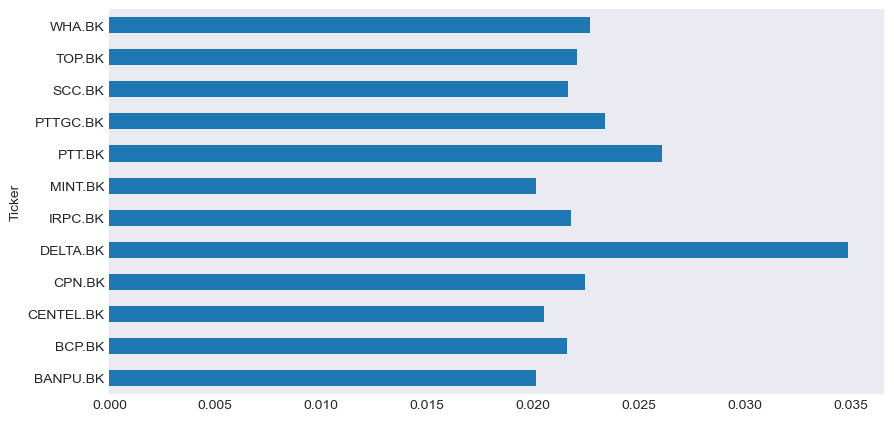

In [10]:
market_prior.plot.barh(figsize=(10,5));


In [11]:
portfolio

Ticker,BANPU.BK,BCP.BK,CENTEL.BK,CPN.BK,DELTA.BK,IRPC.BK,MINT.BK,PTT.BK,PTTGC.BK,SCC.BK,TOP.BK,WHA.BK
Date,,,,,,,,,,,,
2023-01-03,12.099861,29.105591,51.00,68.074379,91.994225,2.886981,31.997322,30.188902,45.603874,337.165314,50.821960,4.052257
2023-01-04,11.558077,28.412600,52.00,68.313232,90.213692,2.847967,32.243454,29.497553,45.847744,340.122925,49.226654,3.955774
2023-01-05,11.558077,28.181604,51.25,67.357811,79.728325,2.867474,32.735722,29.728003,45.360001,344.066376,49.226654,3.878589
2023-01-06,11.106588,28.181604,51.50,68.074379,79.926170,2.867474,32.981857,29.958452,45.116131,345.052246,49.226654,3.917182
2023-01-09,11.287184,28.874594,51.50,67.835526,83.289391,2.906487,32.981857,30.419350,46.335484,347.023956,49.682453,3.897885
2023-01-10,11.287184,29.567585,50.50,66.880089,82.300201,3.023527,33.227985,30.649801,49.018066,352.939178,50.594063,3.820699
2023-01-11,11.196886,29.336588,50.00,66.641235,84.080742,2.984514,33.227985,30.880251,49.261936,353.925018,50.594063,3.897885
2023-01-12,11.106588,31.877550,50.00,66.880089,86.256950,3.043033,33.474121,31.110703,49.018066,350.967407,50.138260,3.859292
2023-01-13,11.287184,34.880508,51.00,66.402382,82.102371,3.062540,33.474121,31.110703,48.774197,349.981567,50.138260,3.782107


In [12]:
views = {}
view_uncertainty = {}
for symbol in symbols:
    X = pd.concat([ext_factors.filter(like='lag'),stock_rets[f'{symbol}_lag']], axis=1)
    pred = predict(X, model_dict[symbol])
    views[symbol] = pred.mean()
    view_uncertainty[symbol] = pred.var()

In [13]:
views

{'MINT.BK': -0.020181252194702286,
 'BANPU.BK': 0.010052435403267591,
 'TOP.BK': -0.0008969691395075966,
 'DELTA.BK': 0.026235090034723338,
 'IRPC.BK': -0.004986589631905548,
 'PTTGC.BK': 0.010907156297797434,
 'WHA.BK': 0.008349102333321997,
 'SCC.BK': 0.003661101830593816,
 'CPN.BK': -0.009342251042961863,
 'CENTEL.BK': -0.000431171697428095,
 'PTT.BK': 0.004525782389259246,
 'BCP.BK': -0.004656466730269359}

In [14]:
view_uncertainty

{'MINT.BK': 9.375063397199297e-05,
 'BANPU.BK': 2.480115536330192e-05,
 'TOP.BK': 3.463115111410517e-05,
 'DELTA.BK': 0.00028559274768358154,
 'IRPC.BK': 4.376182678299651e-05,
 'PTTGC.BK': 0.00021325550095586566,
 'WHA.BK': 3.138414408162785e-05,
 'SCC.BK': 1.4205483997382495e-05,
 'CPN.BK': 4.305222918748461e-05,
 'CENTEL.BK': 4.542016119658813e-05,
 'PTT.BK': 0.00028876537518655903,
 'BCP.BK': 2.5710884537990365e-05}

In [15]:
omega = np.diag(list(view_uncertainty.values()))
omega

array([[9.37506340e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.48011554e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.46311511e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.85592748e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.37618268e-05, 0.00000000e+00, 0.00000000e+00, 0.00

In [24]:
bl = BlackLittermanModel(S, pi="equal", risk_aversion=delta,
                         absolute_views=views, omega=omega)

In [25]:
ret_bl = bl.bl_returns()
ret_bl

Ticker
BANPU.BK     0.010590
BCP.BK      -0.004492
CENTEL.BK    0.000764
CPN.BK      -0.008104
DELTA.BK     0.027101
IRPC.BK     -0.004272
MINT.BK     -0.016983
PTT.BK       0.009729
PTTGC.BK     0.012381
SCC.BK       0.003982
TOP.BK      -0.000327
WHA.BK       0.008973
dtype: float64

In [26]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(views)],
                       index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BANPU.BK,0.020129,0.010590,0.010052
BCP.BK,0.021619,-0.004492,-0.004656
CENTEL.BK,0.020546,0.000764,-0.000431
CPN.BK,0.022463,-0.008104,-0.009342
DELTA.BK,0.034864,0.027101,0.026235
IRPC.BK,0.021786,-0.004272,-0.004987
MINT.BK,0.020171,-0.016983,-0.020181
PTT.BK,0.026123,0.009729,0.004526
PTTGC.BK,0.023409,0.012381,0.010907
SCC.BK,0.021675,0.003982,0.003661


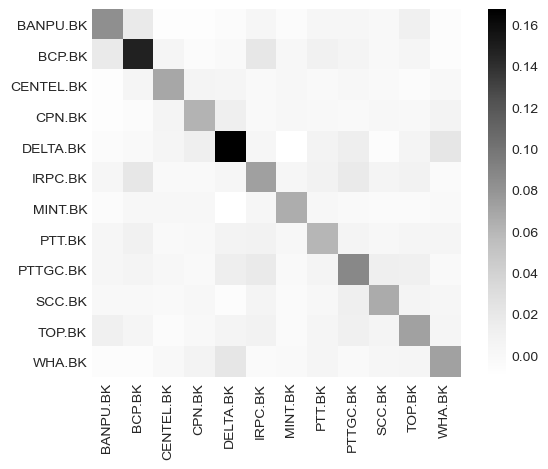

In [27]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [28]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe(risk_free_rate=0.0227/12)
weights = ef.clean_weights()
weights

C:\Users\Eakka\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('BANPU.BK', 0.15026),
             ('BCP.BK', 0.0),
             ('CENTEL.BK', 0.0),
             ('CPN.BK', 0.0),
             ('DELTA.BK', 0.3944),
             ('IRPC.BK', 0.0),
             ('MINT.BK', 0.0),
             ('PTT.BK', 0.13241),
             ('PTTGC.BK', 0.17209),
             ('SCC.BK', 0.036),
             ('TOP.BK', 0.0),
             ('WHA.BK', 0.11485)])

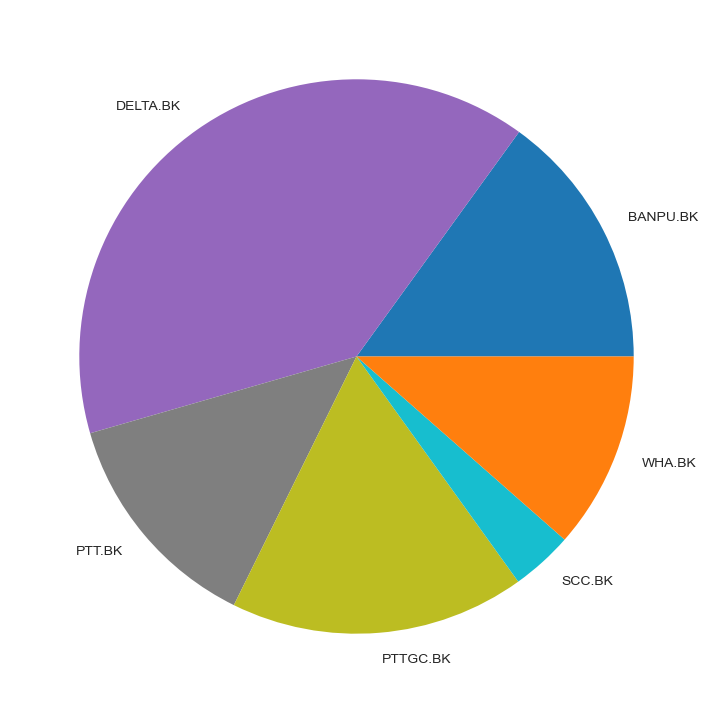

In [29]:
pd.Series(weights).plot.pie(figsize=(9,9));

In [30]:
ef.portfolio_performance(risk_free_rate=0.0227/12, verbose=True)

Expected annual return: 1.7%
Annual volatility: 19.1%
Sharpe Ratio: 0.08


(0.016872625000409164, 0.1911588057133619, 0.07836917728083156)

# Black-Litterman model with monthly rebalancing

In [27]:
stock_rets.index.shape

(95,)